# This notebook is dedicated to EDA

Our main aim is to make use of the various indicators to predict the total sales of games worldwide

In [23]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# data = pd.read_csv("cleaned_data.csv")

# importing main data
vg_sales = pd.read_csv("Final Data.csv")
vg_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61267 entries, 0 to 61266
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          61267 non-null  int64  
 1   Name          61267 non-null  object 
 2   Platform      61267 non-null  object 
 3   Year          56554 non-null  float64
 4   Genre         61267 non-null  object 
 5   Publisher     61267 non-null  object 
 6   Developer     61267 non-null  object 
 7   Critic_Score  6551 non-null   float64
 8   User_Score    402 non-null    float64
 9   NA_Sales      13656 non-null  float64
 10  PAL_Sales     14020 non-null  float64
 11  JP_Sales      7672 non-null   float64
 12  Other_Sales   16365 non-null  float64
 13  Global_Sales  20302 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 6.5+ MB


## Things to note from the initial dataset
* There are a lot of datapoints that have null values
* There are a total of `14` columns with `61267` rows
* There is `1` variable identified as `int64`
* There are `5` variables identified as `object`
* There are `8` variables identified as `float64`



Since there are a lot of datapoints that have null values and we feel that we don't have enough usable indicators, we have decided to merge the dataset with another dataset (metaCritic.csv)

The code for the merging of data is in "data_cleaning.ipynb", and the csv output is saved as "merged_dataSet.csv"

vg_critic score and vg_user_score has a lot of null values. vg_critic score has around 60% of Null Values . Therefore it could be possibel to use Missing forest to fill the null values. As for vg_user_score we have decided to drop the entire column as there are too many null values.

In [10]:
# filling out the missing values using missforest
# from missingpy import MissForest
# imputer = MissForest()
# x = data["vg_critic_score"]

After merging the datasets, we obtain "merged_merged_merged_merged_merged_dataSet.csv" and we will import this as <span style="font-family:Courier New">merged_data</span> for future use

In [22]:
# getting rid of the old dataset to save some memory
del(vg_sales)

# importing new data
merged_data = pd.read_csv("merged_dataSet.csv")

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10996 entries, 0 to 10995
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       10996 non-null  int64  
 1   Name             10996 non-null  object 
 2   Platform         10996 non-null  object 
 3   meta_score       10996 non-null  int64  
 4   meta_UserReview  10996 non-null  object 
 5   vg_Rank          10996 non-null  int64  
 6   Year             10412 non-null  float64
 7   Genre            10996 non-null  object 
 8   Publisher        10996 non-null  object 
 9   Developer        10996 non-null  object 
 10  vg_critic_score  3417 non-null   float64
 11  vg_user_score    261 non-null    float64
 12  NA_Sales         6144 non-null   float64
 13  PAL_Sales        6455 non-null   float64
 14  JP_Sales         2334 non-null   float64
 15  Other_Sales      6930 non-null   float64
 16  Global_Sales     7156 non-null   float64
dtypes: float64(8

In [25]:
merged_data.head()

,Unnamed: 0,Name,Platform,meta_score,meta_UserReview,vg_Rank,Year,Genre,Publisher,Developer,vg_critic_score,vg_user_score,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Global_Sales
0,0.0,The Legend of Zelda: Ocarina of Time,N64,99.0,9.1,470.0,1998.0,Adventure,Nintendo,Nintendo EAD,9.9,10.0,4.10,1.89,1.45,0.16,7.60
1,1.0,Tony Hawk's Pro Skater 2,PS,98.0,7.4,755.0,2000.0,Sports,Activision,Neversoft Entertainment,9.3,NaN,3.05,1.41,0.02,0.20,4.68
2,2.0,Grand Theft Auto IV,PS3,98.0,7.7,337.0,2008.0,Action,Rockstar Games,Rockstar North,10.0,9.0,4.79,3.73,0.44,1.62,10.57
3,3.0,SoulCalibur,DC,98.0,8.4,3425.0,1999.0,Fighting,Namco,Namco,9.6,NaN,NaN,NaN,0.34,0.00,0.34
4,4.0,Grand Theft Auto IV,X360,98.0,7.9,317.0,2008.0,Action,Rockstar Games,Rockstar North,10.0,NaN,6.80,3.11,0.14,1.04,11.09


## Things note from the merged dataset
* meta_score, meta_userReview and an index (the first column) have been added
* Duplicated datapoints have been removed as a result of the merging
* The index columns (first column and vg_rank) are in int64 format
* meta_userReview is identified as an object but it contains float values
* Some columns from the original dataset have been renamed to avoid confusion 
* There are still some null values that we have to deal with
* We assume the NA vales in the sales categories to mean that there were no sales in those regions
* We are predicting the total sales of the games, but there is no data for total sales

In [29]:
# converting meta_userReview to float value

merged_data.loc[(merged_data['meta_UserReview'] == 'tbd')] = None
merged_data['meta_UserReview'] = merged_data['meta_UserReview'].astype(float)

In [30]:
# removing the rows with NULL values for year
merged_data.dropna(subset=['Year'], inplace=True)

# converting Year to an int64 type
merged_data['Year'] = merged_data['Year'].astype(int)

# making sure everything worked
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9940 entries, 0 to 10995
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       9940 non-null   float64
 1   Name             9940 non-null   object 
 2   Platform         9940 non-null   object 
 3   meta_score       9940 non-null   float64
 4   meta_UserReview  9940 non-null   float64
 5   vg_Rank          9940 non-null   float64
 6   Year             9940 non-null   int32  
 7   Genre            9940 non-null   object 
 8   Publisher        9940 non-null   object 
 9   Developer        9940 non-null   object 
 10  vg_critic_score  3335 non-null   float64
 11  vg_user_score    258 non-null    float64
 12  NA_Sales         9940 non-null   float64
 13  PAL_Sales        9940 non-null   float64
 14  JP_Sales         9940 non-null   float64
 15  Other_Sales      9940 non-null   float64
 16  Global_Sales     9940 non-null   float64
dtypes: float64(11

Since we assume that NULL values in the sales categories means that there were no sales in those regions, we shall replace those NULL values with 0

In [31]:
# replacing NULL values with 0
merged_data["NA_Sales"].fillna(0,inplace=True)
merged_data["PAL_Sales"].fillna(0,inplace=True)
merged_data["JP_Sales"].fillna(0,inplace=True)
merged_data["Other_Sales"].fillna(0,inplace=True)
merged_data["Global_Sales"].fillna(0,inplace=True)

# making sure everything worked
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9940 entries, 0 to 10995
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       9940 non-null   float64
 1   Name             9940 non-null   object 
 2   Platform         9940 non-null   object 
 3   meta_score       9940 non-null   float64
 4   meta_UserReview  9940 non-null   float64
 5   vg_Rank          9940 non-null   float64
 6   Year             9940 non-null   int32  
 7   Genre            9940 non-null   object 
 8   Publisher        9940 non-null   object 
 9   Developer        9940 non-null   object 
 10  vg_critic_score  3335 non-null   float64
 11  vg_user_score    258 non-null    float64
 12  NA_Sales         9940 non-null   float64
 13  PAL_Sales        9940 non-null   float64
 14  JP_Sales         9940 non-null   float64
 15  Other_Sales      9940 non-null   float64
 16  Global_Sales     9940 non-null   float64
dtypes: float64(11

Since we are predicting total sales and there is no column for that, we will add one column for total sales by summing all sales

In [32]:
# summing sales values and creating a new column
merged_data["Total_Sales"]= merged_data["NA_Sales"] + merged_data["PAL_Sales"] + merged_data["JP_Sales"] + merged_data["Other_Sales"] + merged_data["Global_Sales"]

# making sure everything worked
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9940 entries, 0 to 10995
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       9940 non-null   float64
 1   Name             9940 non-null   object 
 2   Platform         9940 non-null   object 
 3   meta_score       9940 non-null   float64
 4   meta_UserReview  9940 non-null   float64
 5   vg_Rank          9940 non-null   float64
 6   Year             9940 non-null   int32  
 7   Genre            9940 non-null   object 
 8   Publisher        9940 non-null   object 
 9   Developer        9940 non-null   object 
 10  vg_critic_score  3335 non-null   float64
 11  vg_user_score    258 non-null    float64
 12  NA_Sales         9940 non-null   float64
 13  PAL_Sales        9940 non-null   float64
 14  JP_Sales         9940 non-null   float64
 15  Other_Sales      9940 non-null   float64
 16  Global_Sales     9940 non-null   float64
 17  Total_Sales  

## 2. things to compare:
1. genre vs global sales
2. platform vs global sales (we will remove the platforms that are small, so that we can focus on the bigger picture)
3. correlation between regional sales vs platform (is there a region that likes a particular platform?)
4. correlation between regional sales vs genre (is there a region that likes a particular genre?)
5. correlation between regional sales vs global sales

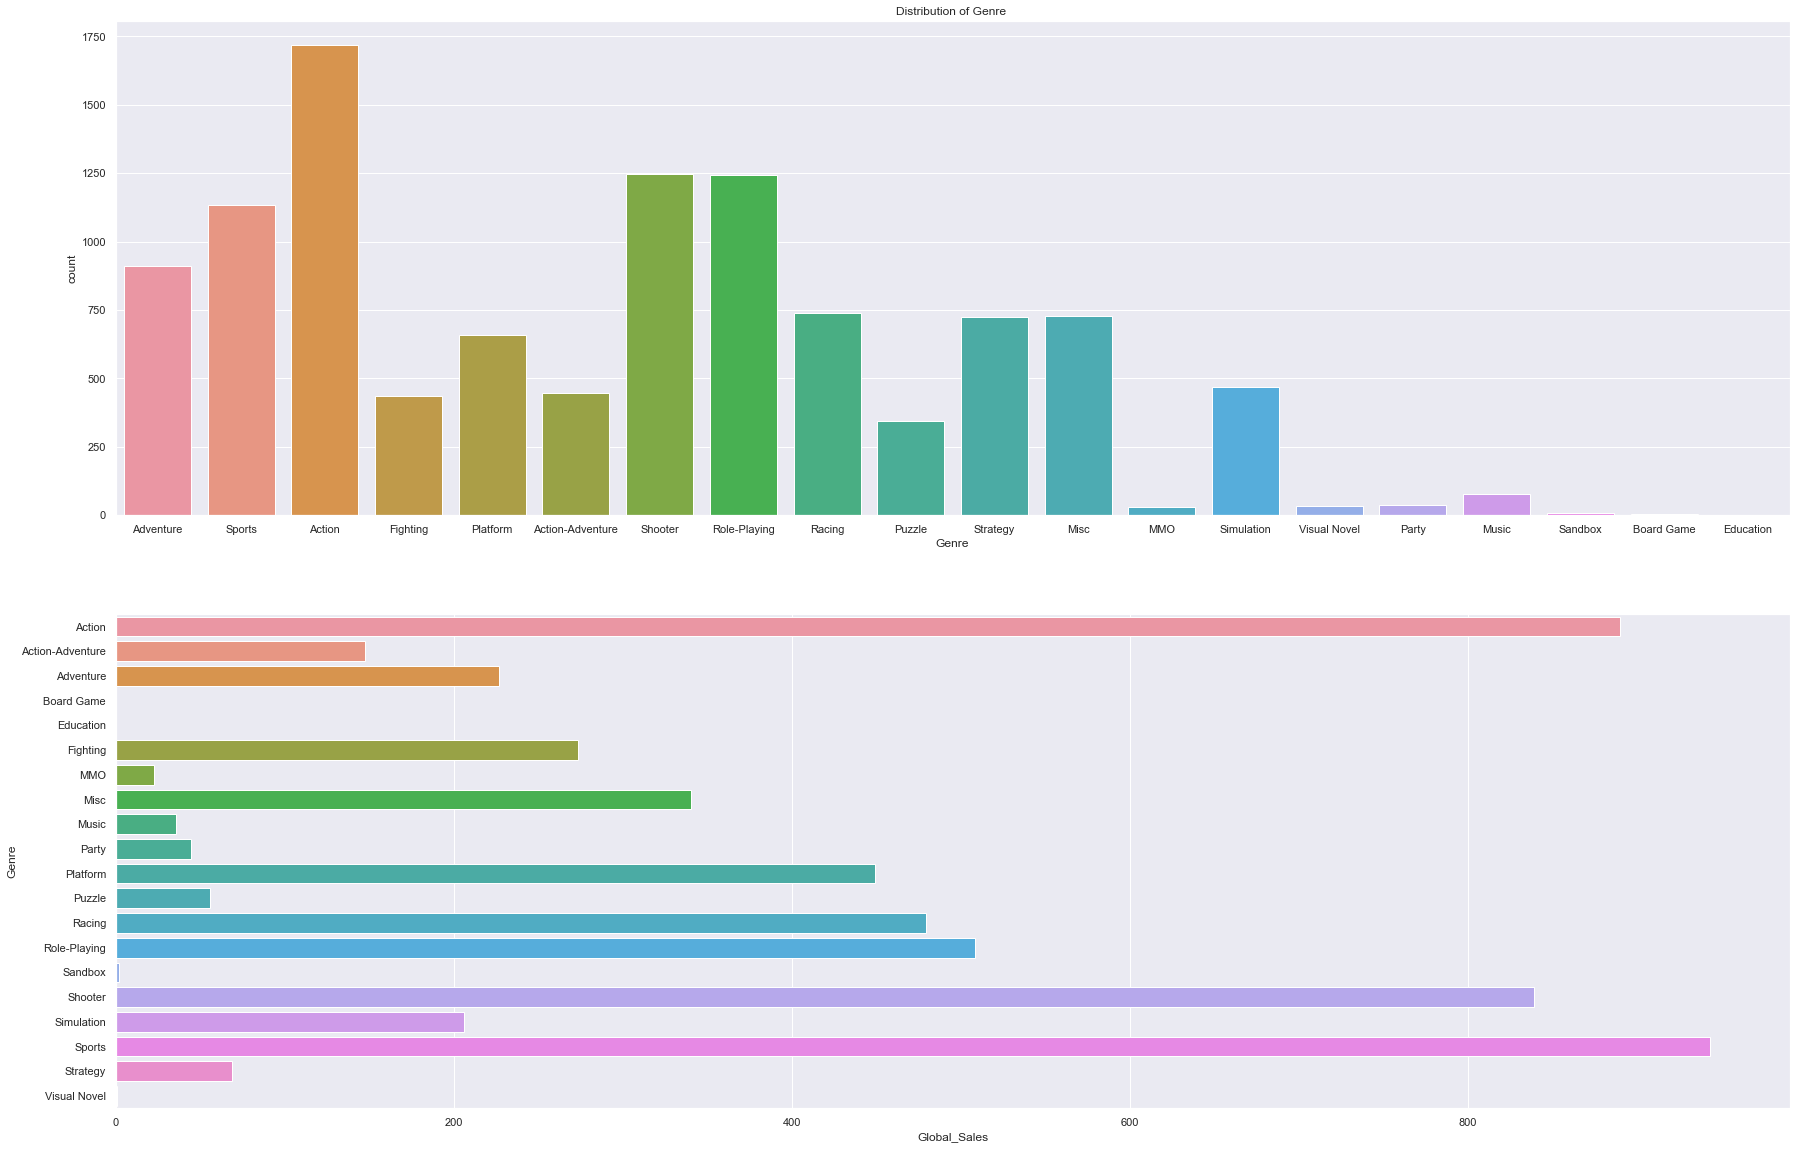

In [13]:
# genre vs global sales
f,axes = plt.subplots(2,1,figsize=(30,20))
axes[0].set_title("Distribution of Genre ")
sb.countplot(x="Genre", data = merged_data , ax = axes[0])

genereSale = merged_data.groupby('Genre')['Global_Sales'].sum()
p = sb.barplot(y=genereSale.index, x=genereSale,ax=axes[1])

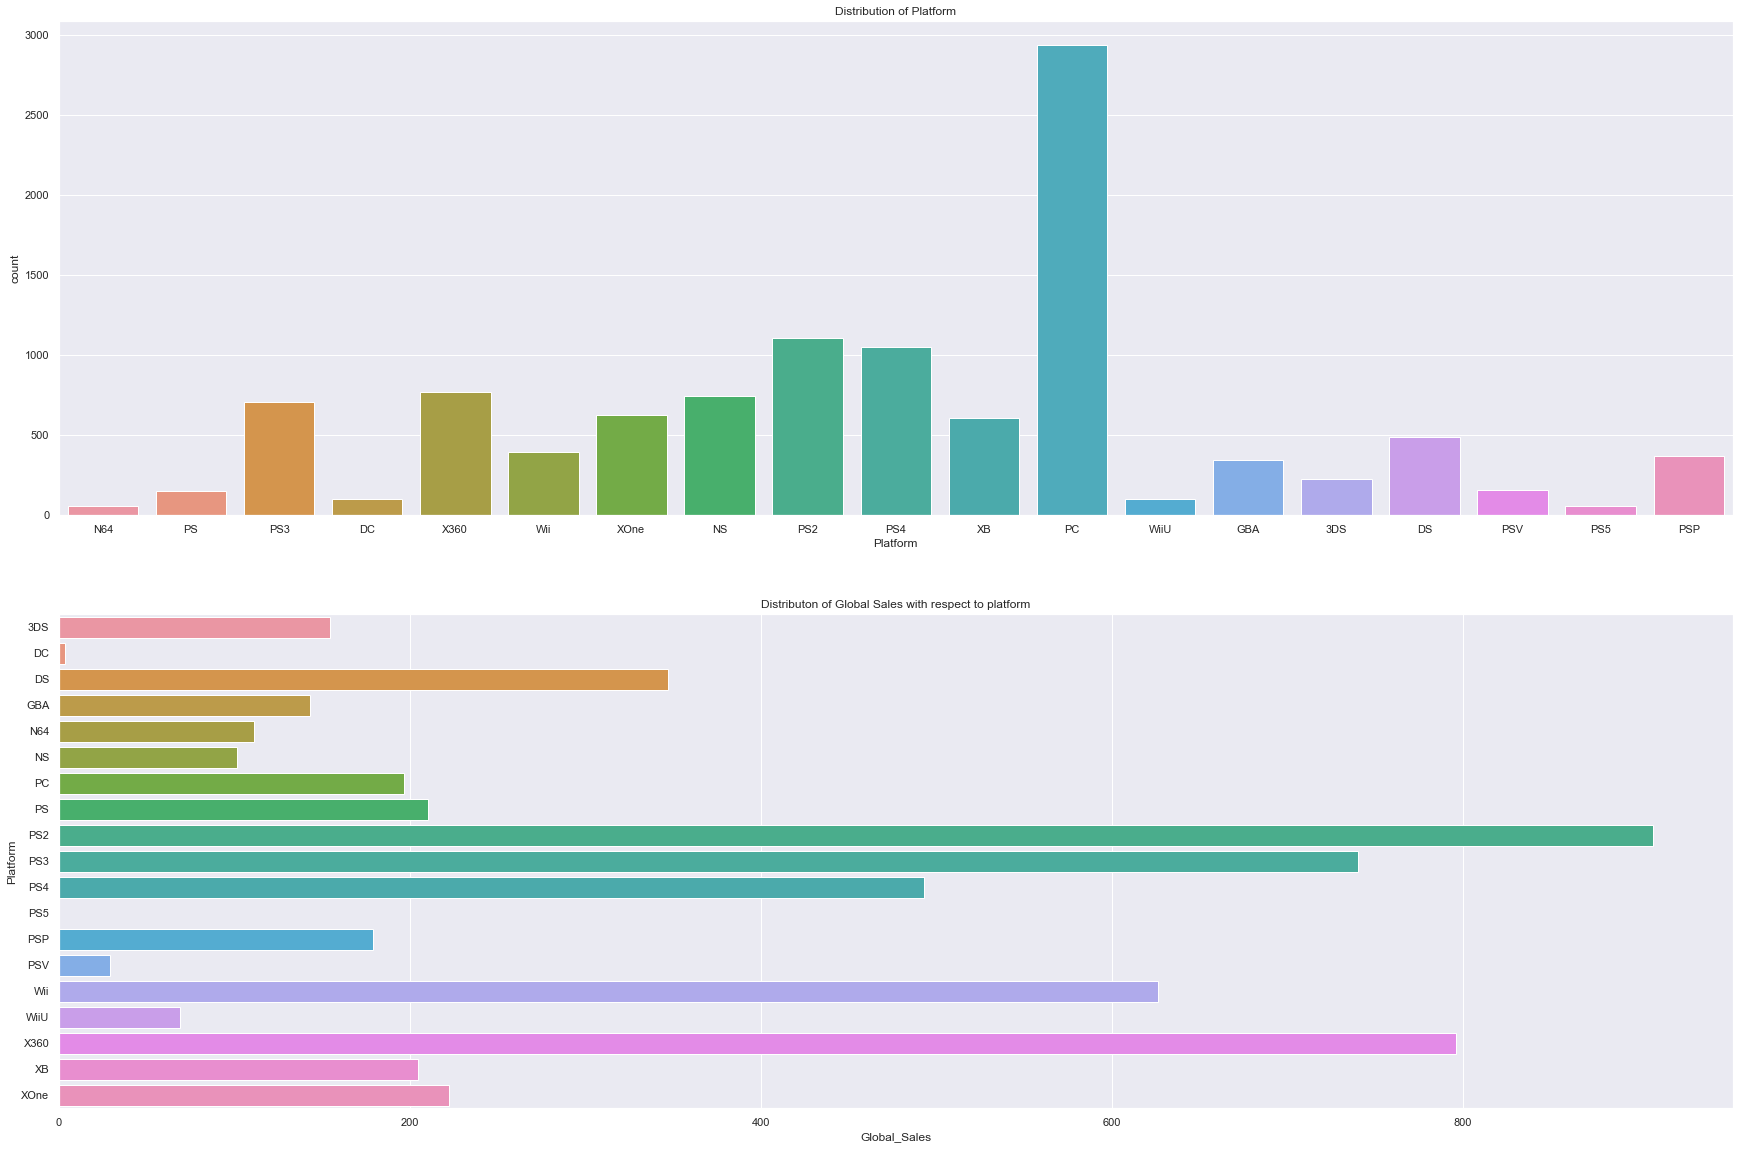

In [14]:
# platform vs global sales
f,axes = plt.subplots(2,1,figsize=(30,20))
axes[0].set_title("Distribution of Platform")
sb.countplot(x="Platform", data = merged_data , ax = axes[0])

platformSale = merged_data.groupby('Platform')['Global_Sales'].sum()
axes[1].set_title("Distributon of Global Sales with respect to platform")
p = sb.barplot(y=platformSale.index, x=platformSale,ax=axes[1])

In [15]:
#correlation between regional sales and platform

In [16]:
#Identifying top games per year based on the different predictors

top_game = merged_data.groupby('Year')['Global_Sales']
top_game.head()


0         7.60
1         4.68
2        10.57
3         0.34
4        11.09
         ...  
5402       NaN
7298       NaN
9031      0.03
10335      NaN
10584      NaN
Name: Global_Sales, Length: 147, dtype: float64

## 3. main issues
1. we realised that we don't have a lot of indicators to work with, so we merged another dataset and cleaned it (can add in the cleaning code here a bit ah). this gives us more indicators to work with.

## 4. more things to compare:
1. correlation between meta score and all sales (regional + global) -> is meta score a good indicator of sales in general?
2. correlation between user review and all sales (regional + global) -> is user review a good indicator of sales in general?

## 5. end of EDA
- we decide on what indicators we are using, based on the results that we get from the EDA

In [17]:
ml = merged_data
ml.drop("Genre",axis =1,inplace = True)
ml.drop("vg_user_score",axis =1,inplace = True)
ml.head()
ml.to_csv('ml_dataSet.csv')

